In [1]:
from EEResnet18 import ResNet, ResidualBlock, data_loader
import numpy as np
import torch
import torch.nn as nn
import torch.backends
import torch.backends.mps
import torch.mps
import torch.nn.functional as F
from tqdm import tqdm

Setting RESNET-18 device as mps


In [2]:
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64, data_model="cifar10")

test_loader = data_loader(data_dir='./data',
                              batch_size=1,
                              test=True, data_model="cifar10")

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Setting TEST device as {device}")

device = torch.device(device)

Files already downloaded and verified
Files already downloaded and verified
50000
Files already downloaded and verified
Setting TEST device as mps


In [3]:
earlyExitLayers = [1, 4]
ealyExitNumber = len(earlyExitLayers)
criterion = nn.CrossEntropyLoss()

def calculate_loss(pred, target):
    cum_loss = []
    accuracy = []
    for i in range(ealyExitNumber + 1):
        cum_loss.append(criterion(pred[i], target))
        # print(salap)
        _, predicted = torch.max(pred[i].data, 1)
        accuracy.append((predicted == target).sum().item())

    return cum_loss, accuracy

In [4]:
num_classes = 10
num_epochs = 10
# batch_size = 16
learning_rate = 0.01

model = ResNet().to(device)
# model.requires_grad_ = True
# model = ResNet()
model.make_backbone(ResidualBlock, [2, 2, 2, 2], earlyExitLayers, num_classes)

# Loss and optimizer

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)  

# Train the model
# total_step = len(train_loader)
# print(len(train_loader))
import gc
total_step = len(train_loader)
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} ================")
    # n_batch = (n_sample - 1) // batch_size + 1
    model.train()
    total_sample = 0
    total_loss = total_accuracy = 0
    layers_accuracy = []
    losses = []
    [layers_accuracy.append(0) for i in range(ealyExitNumber + 1)]
    # for j in range(1):
    with tqdm(total=total_step) as bar_step:
        for i, (images, labels) in enumerate(train_loader): 
            # print(i) 
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            # print(outputs[-1].size())
            # _, predicted = torch.max(outputs.data, 1)
            # total_accuracy += (predicted == labels).sum().item()
            # loss = criterion(outputs[-1], labels)
            optimizer.zero_grad()
            loss, accuracy = calculate_loss(outputs, labels)
            for j in range(len(accuracy)):
                layers_accuracy[j] += accuracy[j]
            # print(loss)
            # print(accuracy)
            # total_loss += loss
            # losses.append(float(loss))
            total_sample += labels.size(0)

             # Backward and optimize
            loss[0].backward(retain_graph=True)
            loss[1].backward(retain_graph=True)
            loss[2].backward()
            optimizer.step()
            del images, labels, outputs
            torch.mps.empty_cache() if torch.backends.mps.is_available() else torch.cuda.empty_cache()
            gc.collect()

            if (i + 1) % 3 == 0 or i + 1 == total_step + 1:
                bar_step.set_postfix({
                            'avg_loss': float(total_loss) / (i + 1),
                            'avg_accuracy': (sum(layers_accuracy)/3) / (i + 1),
                            # 'max_abs_gradient': np.max(abs(model.weight.grad))
                        })
                cur_n_batch = i % 3 + 1
                bar_step.update(cur_n_batch)

    # print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, round(np.mean(losses))))
    for p in range(len(layers_accuracy)):
        accuracy1 = 100 * layers_accuracy[p] / total_sample
        print(f'Epoch {epoch+1}: Accuracy of Exit layer {p + 1} = {accuracy1:.2f}%')
        
    # model.eval()
                
        # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs[-1].data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

i = 1
i = 1
i = 1
i = 1
Epoch 1 ================


100%|█████████▉| 702/704 [08:25<00:01,  1.39it/s, avg_loss=0, avg_accuracy=29.1]


Epoch 1: Accuracy of Exit layer 1 = 40.96%
Epoch 1: Accuracy of Exit layer 2 = 47.36%
Epoch 1: Accuracy of Exit layer 3 = 48.32%
Accuracy of the network on the 5000 validation images: 62.8 %
Epoch 2 ================


100%|█████████▉| 702/704 [08:29<00:01,  1.38it/s, avg_loss=0, avg_accuracy=39.6]


Epoch 2: Accuracy of Exit layer 1 = 51.25%
Epoch 2: Accuracy of Exit layer 2 = 65.42%
Epoch 2: Accuracy of Exit layer 3 = 69.06%
Accuracy of the network on the 5000 validation images: 72.24 %
Epoch 3 ================


100%|█████████▉| 702/704 [08:26<00:01,  1.39it/s, avg_loss=0, avg_accuracy=43.5]


Epoch 3: Accuracy of Exit layer 1 = 54.58%
Epoch 3: Accuracy of Exit layer 2 = 72.26%
Epoch 3: Accuracy of Exit layer 3 = 77.09%
Accuracy of the network on the 5000 validation images: 78.8 %
Epoch 4 ================


 62%|██████▏   | 435/704 [05:15<03:14,  1.38it/s, avg_loss=0, avg_accuracy=45.7]


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs[-1].data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

In [9]:
from torchview import draw_graph
# from torchvision.models import resnet18, GoogLeNet, densenet, vit_b_16
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

'svg'

In [13]:
model = ResNet().to(device="cpu")
# model.requires_grad_ = True
# model = ResNet()
model.make_backbone(ResidualBlock, [2, 2, 2, 2], [1, 4], 10)

i = 1
i = 1
i = 1
i = 1


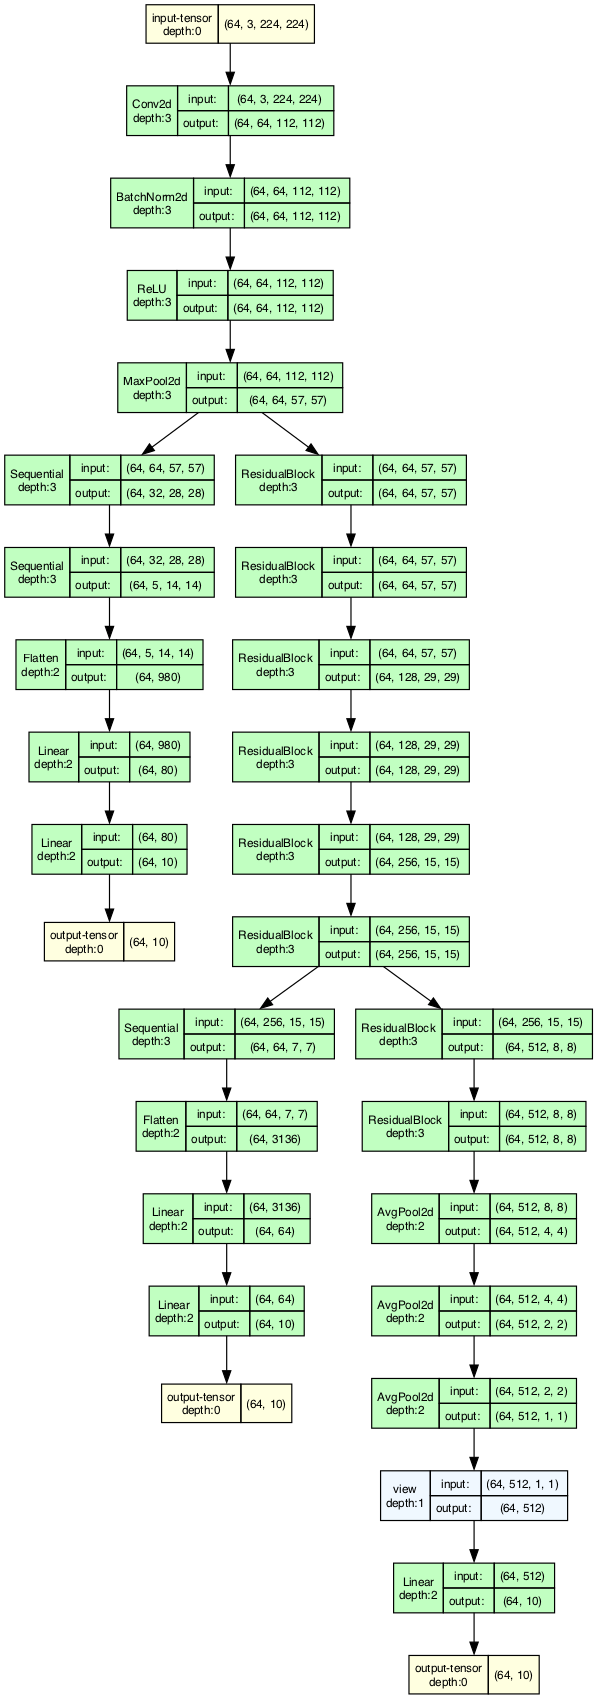

In [14]:
model_graph1 = draw_graph(model, input_size=(64, 3, 224, 224), device="cpu")
model_graph1.visual_graph

In [4]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs[-1].data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 60.47 %


In [5]:
torch.save(model.state_dict(), "model/RESNET_18-CIFAR_10-SGD-Early_Exit_in_1st_layer-MPS_eww.pth")